In [1]:
%reload_ext autoreload

In [32]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0

In [40]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
sys.path.append('../lib')
import utils
import preprocessing

In [5]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [6]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw)
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
5889 (5889, 101)


In [13]:
#utils.data_summary(df_processed)

In [8]:
df_filtered = df_processed[df_processed.licence_registration_Year >2017]
print(len(df_filtered), df_filtered.shape)

1351 (1351, 101)


In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
#display_all(df_filtered)

print(len(df_filtered[df_filtered.nps_detractor == 1]),len(df_filtered[df_filtered.nps_passive == 1]),len(df_filtered[df_filtered.nps_promoter == 1]))


1256 30 35


In [16]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(412, 939)

In [17]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

1351 (1351, 104)


In [18]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [19]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res.shape

(1040, 104)

In [20]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(412, 939)

In [21]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
[0.6206896551724138, 0.4444444444444444, 0.5179856115107913, 0.866, 0.4426327698655663, 0.134]
[[397  22]
 [ 45  36]]


['churn_model.pkl']

In [22]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
2,days_active,0.184993
58,plan_PLAN-S-17Q2,0.115906
9,cases_open,0.084587
10,cases_closed,0.072222
11,cases_age_hours_total,0.070001
8,cases_total,0.065006
59,plan_PLAN-S-19Q1,0.059896
14,interactions_total,0.056263
15,interactions_completed,0.036293
13,annual_revenue,0.030922


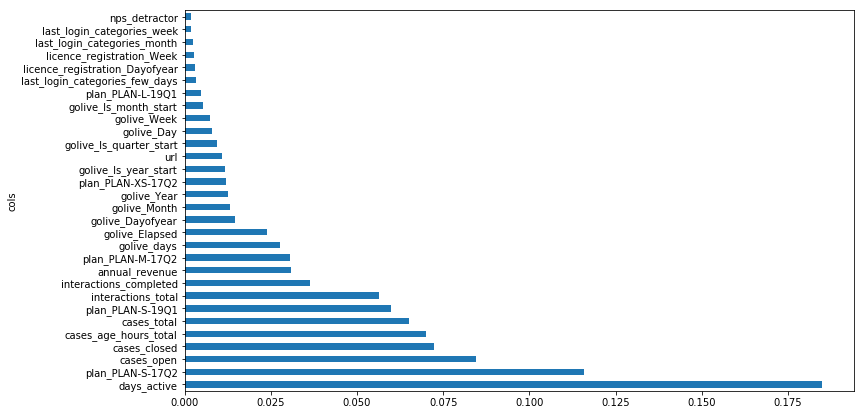

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [26]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [27]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

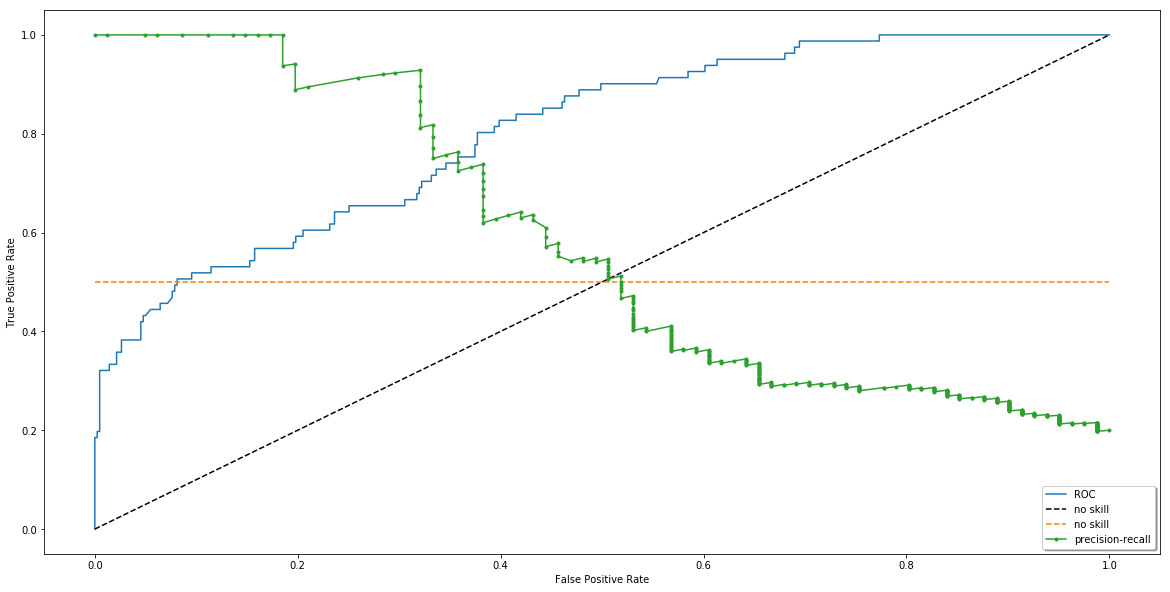

auc=0.578 ap=0.580


In [37]:
utils.plot_roc_pr(m, X_valid, y_valid)

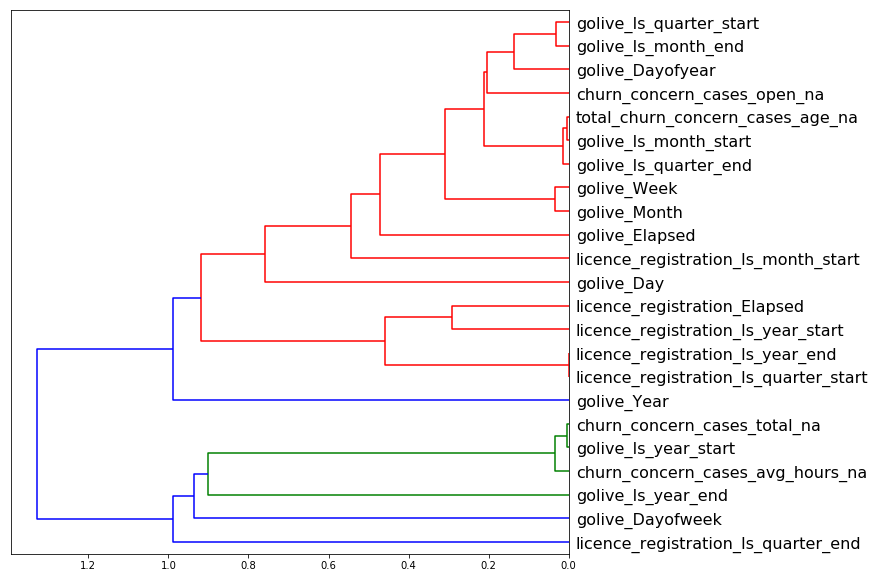

In [64]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [66]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9806451612903225 0.459214501510574 0.6255144032921811 0.7861339600470035 0.5019487034369212 0.21386603995299647
days_active None
1.0 0.6918429003021148 0.8178571428571428 0.8801410105757932 0.7328856912500539 0.11985898942420682
plan_PLAN-S-17Q2 None
1.0 0.6888217522658611 0.815742397137746 0.8789659224441834 0.7301099537215223 0.12103407755581669
cases_open None
1.0 0.676737160120846 0.8072072072072072 0.8742655699177438 0.7189746217019477 0.12573443008225618
cases_closed None
1.0 0.6858006042296072 0.8136200716845878 0.8777908343125734 0.7273309836590837 0.12220916568742655
cases_age_hours_total None
1.0 0.6888217522658611 0.815742397137746 0.8789659224441834 0.7301099537215223 0.12103407755581669
cases_total None
1.0 0.7039274924471299 0.8262411347517731 0.8848413631022327 0.7439564285670426 0.11515863689776733
plan_PLAN-S-19Q1 None
1.0 0.6827794561933535 0.8114901256732496 0.8766157461809636 0.72454877541269